# 2023-04-19 Differential Equations

## Last time

* Singular integrals and Tanh-Sinh quadrature
* Finite element integration and mapped elements
* Integration in multiple dimensions

## Today

* Notes on integration
* Ordinary differential equations (ODE)
* Explicit methods for solving ODE
* Stability

In [83]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)
heun = RKTable([0 0; 1 0], [.5, .5])
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Notes on integration

* Transforms can make the integrand smooth
* Transforms can make the domain shape more convenient
* Adaptive integration
* Curse of dimensionality
  * Sparse grids ([Smolyak quadrature](https://en.wikipedia.org/wiki/Sparse_grid#Smolyak%27s_quadrature_rule))
  * Adaptive randomized methods (Markov Chain Monte Carlo)

## High-dimensional integrals

Suppose we have a joint probability density $p(x; y)$.

* Perhaps it's the probability of getting $x$ inches of snow, where $y$ represents known and unknown quantities (location, season, wind direction, El Niño year).
* The marginal distribution $p(x)$ allows us to incorporate knowledge (and uncertainty) of $y$ to make a distribution over only $x$.

$$p(x) = \int_y p(x; y) p_Y(y)$$

* Curve ball: we aren't given $p(x;y)$ or $p_Y(y)$, but we can use data and models to sample those distributions.

# Ordinary Differential Equations

Given initial condition $y_0 = y(t=0)$, find $y(t)$ for $t > 0$ that satisfies

$$ y' \equiv \dot y \equiv \frac{\partial y}{\partial t} = f(t, y) $$

| Application | $y$ | $f$ |
| --- | --- | --- |
| Orbital dynamics | position, momentum | conservation of momentum|
| Chemical reactions | concentration | conservation of atoms |
| Epidemiology | infected/recovered population | transmission and recovery |

* $y$ can be a scalar or a vector

# Why a causal model?
## How was IHME making predictions in March/April 2020?

![](../img/ihme-cumulative-death-rate.png)

![](../img/ihme-spain-extrapolation.png)

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">26. Here&#39;s an interesting example of the perversity of the curve-fit. <br><br>The model has been consistently underestimating deaths in Spain. But it has to match the back side of the curve to the front side. To do that it has to *steepen* the downward trajectory. <a href="https://t.co/LzKRDv9BoO">pic.twitter.com/LzKRDv9BoO</a></p>&mdash; Carl T. Bergstrom (@CT_Bergstrom) <a href="https://twitter.com/CT_Bergstrom/status/1250369165984010241?ref_src=twsrc%5Etfw">April 15, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

# Solving differential equations


## Linear equations

$$ y' = A(t) y + \text{source}(t)$$

* Autonomous if $A(t) = A$ and source independent of $t$

* Suppose $y$ and $a = A$ are scalars: $y(t) = e^{at} y_0$

## Can do the same for systems

$$ y(t) = e^{A t} y_0 $$

### What does it mean to exponentiate a matrix?

Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](http://www.cs.cornell.edu/cv/ResearchPDF/19ways+.pdf).


## Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

# Forward Euler Method
The simplest method for solving $y'(t) = f(t,y)$ is
to use numerical differentiation to write
$$ y' \approx \frac{y(h) - y(0)}{h} $$
which yields the solution estimate
$$ \tilde y(h) = y(0) + h f(0, y(0)) $$
where $h$ is the step size.
Let's try this on a scalar problem
$$ y' = -k (y - \cos t) $$
where $k$ is a parameter controlling the rate at which the solution $u(t)$ is pulled toward the curve $\cos t$.

In [3]:
function ode_euler(f, y0; tfinal=10., h=0.1)
    y = copy(y0)
    t = 0.
    thist = [t]
    yhist = [y0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        y += h * f(t, y)
        t = tnext
        push!(thist, t)
        push!(yhist, y)
    end
    thist, hcat(yhist...)
end

ode_euler (generic function with 1 method)

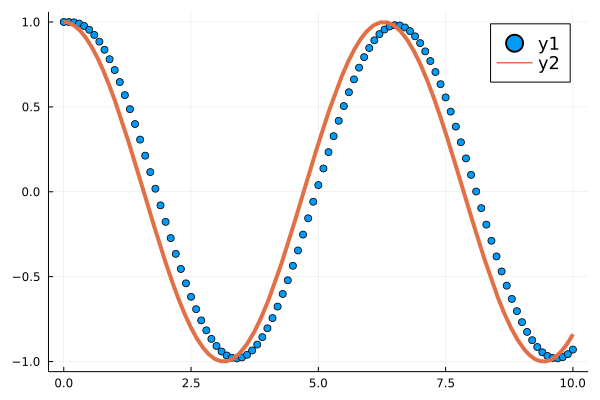

In [6]:
f1(t, y; k=4) = -k * (y .- cos(t))

thist, yhist = ode_euler(f1, [1.], tfinal=10, h=.1)
scatter(thist, yhist[1,:])
plot!(cos)

# Forward Euler on a linear system

$$ \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}' = \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}$$

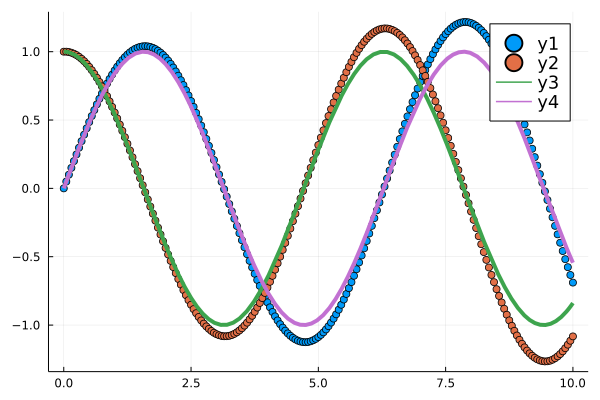

In [9]:
f2(t, y) = [0 1; -1 0] * y

thist, yhist = ode_euler(f2, [0., 1], h=.05, tfinal=10)
scatter(thist, yhist')
plot!([cos, sin])

In [8]:
eigen([0 1; -1 0])

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im
vectors:
2×2 Matrix{ComplexF64}:
 0.707107-0.0im       0.707107+0.0im
      0.0-0.707107im       0.0+0.707107im

# Runge-Kutta 4

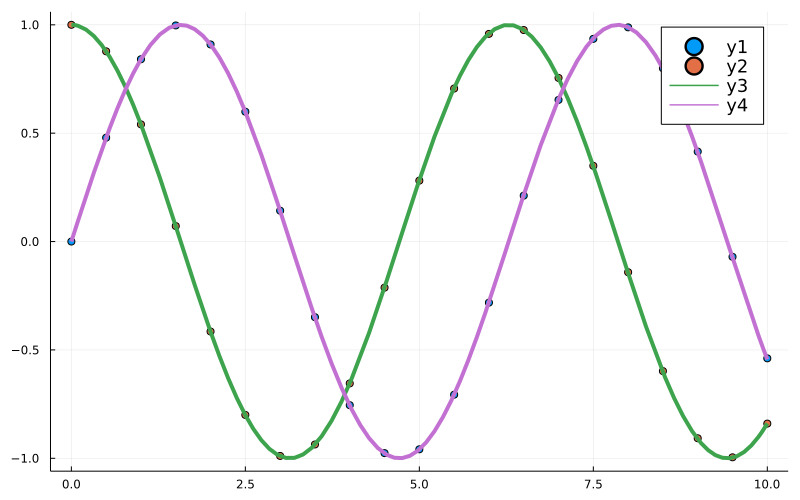

In [51]:
thist, yhist = ode_rk_explicit(f2, [0., 1], h=.5, tfinal=10)
scatter(thist, yhist')
plot!([cos, sin], size=(800, 500))

* Apparently it is possible to integrate this system using large time steps.
* This method evaluates $f(y)$ four times per stepso the cost is about equal when the step size $h$ is 4x larger than forward Euler.

# Linear Stability Analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?
And why do both methods diverge if the step size is too large?
We can understand the convergence of methods by analyzing the test problem
$$ y' = \lambda y $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ y \to y + h \lambda y = \underbrace{(1 + h \lambda)}_{R(h \lambda)} y .$$
When does this map cause solutions to "blow up" and when is it stable?

In [79]:
function plot_stability(Rz, method; xlim=(-3, 2), ylim=(-1.5, 1.5))
    x = xlim[1]:.02:xlim[2]
    y = ylim[1]:.02:ylim[2]
    plot(title="Stability: $method", aspect_ratio=:equal, xlim=xlim, ylim=ylim)
    heatmap!(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2))
    plot!(x->0, color=:black, linewidth=1, label=:none)
    plot!([0, 0], [ylim...], color=:black, linewidth=1, label=:none)
end

plot_stability (generic function with 2 methods)

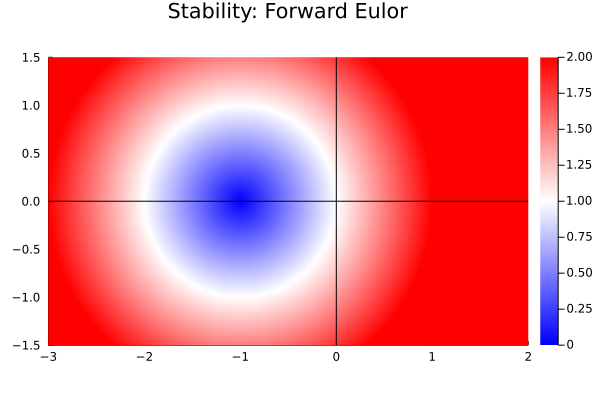

In [80]:
plot_stability(z -> 1 + z, "Forward Eulor")

# Stability for RK4

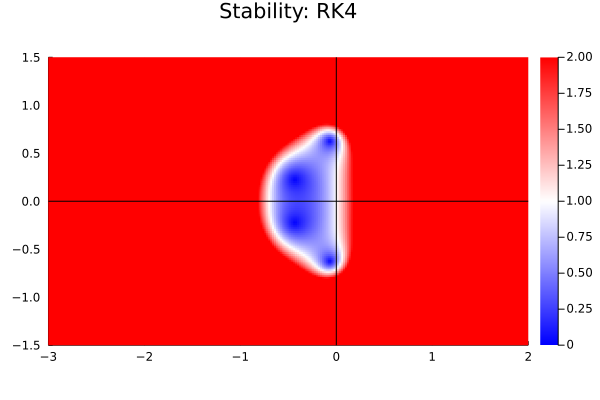

In [81]:
plot_stability(z -> rk_stability(4z, rk4), "RK4")


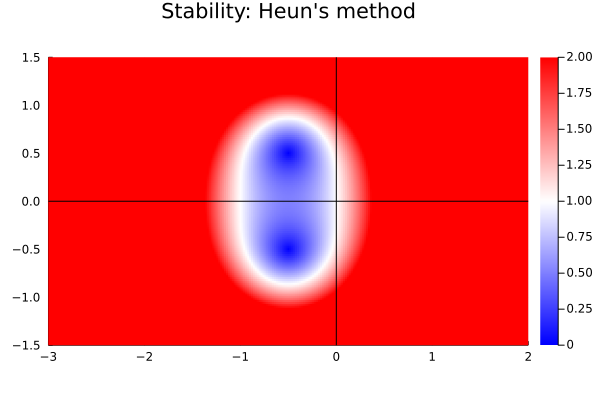

In [82]:
plot_stability(z -> rk_stability(2z, heun), "Heun's method")

# Implicit methods

Recall that forward Euler is the step
$$ \tilde y(h) = y(0) + h f(0, y(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde y(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde y(h) = y(0) + h f(h, \tilde y(h)) . $$
This is a (generally) nonlinear equation for $\tilde y(h)$.
For the test equation $y' = \lambda y$, the backward Euler method is
$$ \tilde y(h) = y(0) + h \lambda \tilde y(h) $$
or
$$ \tilde y(h) = \underbrace{\frac{1}{1 - h \lambda}}_{R(h\lambda)} y(0) . $$

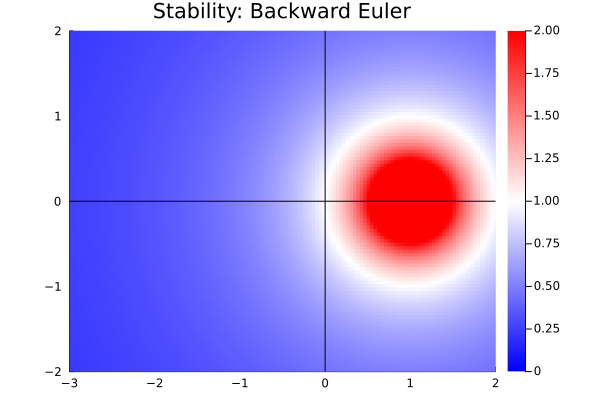

In [59]:
plot_stability(z -> 1/(1-z), "Backward Euler")

# Computing with implicit methods

$$ \tilde y(h) = y(0) + h f\big(\tilde y(h) \big) $$

* Linear solve for linear problem
* Nonlinear (often Newton) solve for nonlinear problem
* Need Jacobian or finite differencing

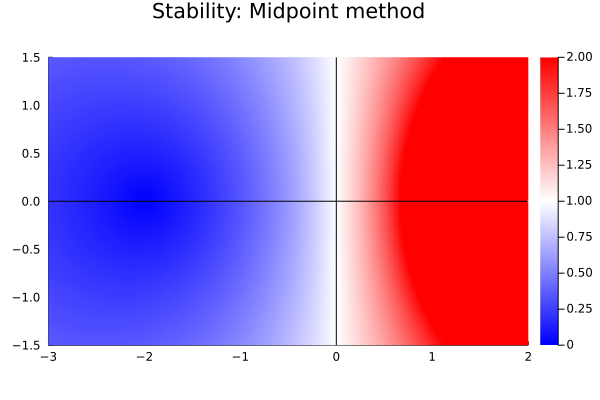

In [84]:
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")